In [23]:
import requests, json, time, re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
%matplotlib inline

In [2]:
legal = pd.read_csv("./legal_advice.csv")

In [3]:
unpopular = pd.read_csv("./unpopular_opinion.csv")

In [4]:
data = pd.concat([legal, unpopular], axis = 0)

In [5]:
data.head()

,title,posts,subreddit
0,[Super Awesome Update] Sat down on my friend's...,I never thought this would turn out the way it...,legaladvice
1,(Update) Neighbors child has disabilities and ...,Original post: https://www.reddit.com/r/legala...,legaladvice
2,I think my boyfriend has been drugging me to m...,This is in north Texas. \n\nHey so I must apol...,legaladvice
3,Neighbors assaulted me and took my daughter (l...,"Male, late 20’s, CO\n\nI quit drinking soda an...",legaladvice
4,"I told my math teacher about my mother, and sh...",I got my 13 year old brother after school yest...,legaladvice


In [6]:
data['text'] = data['title'] + data['posts']

In [7]:
data.head()

,title,posts,subreddit,text
0,[Super Awesome Update] Sat down on my friend's...,I never thought this would turn out the way it...,legaladvice,[Super Awesome Update] Sat down on my friend's...
1,(Update) Neighbors child has disabilities and ...,Original post: https://www.reddit.com/r/legala...,legaladvice,(Update) Neighbors child has disabilities and ...
2,I think my boyfriend has been drugging me to m...,This is in north Texas. \n\nHey so I must apol...,legaladvice,I think my boyfriend has been drugging me to m...
3,Neighbors assaulted me and took my daughter (l...,"Male, late 20’s, CO\n\nI quit drinking soda an...",legaladvice,Neighbors assaulted me and took my daughter (l...
4,"I told my math teacher about my mother, and sh...",I got my 13 year old brother after school yest...,legaladvice,"I told my math teacher about my mother, and sh..."


In [8]:
data['subreddit'].replace('legaladvice', 1, inplace=True)
data['subreddit'].replace('unpopularopinion', 0, inplace=True)

In [9]:
data.head()

,title,posts,subreddit,text
0,[Super Awesome Update] Sat down on my friend's...,I never thought this would turn out the way it...,1,[Super Awesome Update] Sat down on my friend's...
1,(Update) Neighbors child has disabilities and ...,Original post: https://www.reddit.com/r/legala...,1,(Update) Neighbors child has disabilities and ...
2,I think my boyfriend has been drugging me to m...,This is in north Texas. \n\nHey so I must apol...,1,I think my boyfriend has been drugging me to m...
3,Neighbors assaulted me and took my daughter (l...,"Male, late 20’s, CO\n\nI quit drinking soda an...",1,Neighbors assaulted me and took my daughter (l...
4,"I told my math teacher about my mother, and sh...",I got my 13 year old brother after school yest...,1,"I told my math teacher about my mother, and sh..."


In [10]:
data.shape

(2054, 4)

In [11]:
data.drop_duplicates(inplace=True)

In [12]:
data.shape

(1829, 4)

In [13]:
data.isnull().sum()

title        0
posts        7
subreddit    0
text         7
dtype: int64

In [14]:
data[data['posts'].isnull()]

,title,posts,subreddit,text
11,Deadbeat dad ditched my mom when she was pregn...,NaN,1,NaN
83,NY- I sent a rent check to landlord who then c...,NaN,1,NaN
206,I work for a privately owned brewery/restauran...,NaN,1,NaN
304,Police Officer: I am going to search your vehi...,NaN,1,NaN
459,i’m 16 and from england my grandad passed and ...,NaN,1,NaN
592,FL: My schizophrenic neighbor has over 30 time...,NaN,1,NaN
643,"TN: Work overpaid me ($15,000 instead of $1500...",NaN,1,NaN


In [15]:
data.replace(np.nan, "", inplace = True)

In [16]:
data[data['posts'].isnull()]

,title,posts,subreddit,text


In [17]:
data['subreddit'].value_counts(normalize=True) # my benchmark (53%)

1    0.533625
0    0.466375
Name: subreddit, dtype: float64

In [18]:
data['posts'] = data.posts.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x)) # getting rid of slashes and spaces
data['posts'] = data.posts.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x)) # getting rid of url
data['posts'] = data.posts.map(lambda x: re.sub('(legal|advice)[s]?', ' ', x,  flags=re.I))
data['posts'] = data.posts.map(lambda x: re.sub('(unpopular|opinion)[s]?', ' ', x,  flags=re.I))

In [19]:
data.head()

,title,posts,subreddit,text
0,[Super Awesome Update] Sat down on my friend's...,I never thought this would turn out the way it...,1,[Super Awesome Update] Sat down on my friend's...
1,(Update) Neighbors child has disabilities and ...,Original post: \n\nI'm sad about this update ...,1,(Update) Neighbors child has disabilities and ...
2,I think my boyfriend has been drugging me to m...,This is in north Texas. \n\nHey so I must apol...,1,I think my boyfriend has been drugging me to m...
3,Neighbors assaulted me and took my daughter (l...,"Male, late 20’s, CO\n\nI quit drinking soda an...",1,Neighbors assaulted me and took my daughter (l...
4,"I told my math teacher about my mother, and sh...",I got my 13 year old brother after school yest...,1,"I told my math teacher about my mother, and sh..."


In [20]:
X = data.drop('subreddit', 1)
y = data['subreddit']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=24)

In [29]:
cvec = CountVectorizer(max_features = 500, stop_words = 'english')

In [30]:
train_df = pd.DataFrame(cvec.fit_transform(X_train['posts']).todense(),
                          columns = cvec.get_feature_names())

In [31]:
test_df = pd.DataFrame(cvec.transform(X_test['posts']).todense(),
                         columns = cvec.get_feature_names())

In [32]:
train_df.fillna(0, inplace=True)

In [33]:
train_df.isnull().sum()

000           0
10            0
100           0
12            0
15            0
18            0
20            0
30            0
able          0
absolutely    0
account       0
act           0
action        0
actual        0
actually      0
address       0
age           0
ago           0
agree         0
agreed        0
airbnb        0
allowed       0
amp           0
angry         0
animal        0
answer        0
anymore       0
apartment     0
apparently    0
area          0
             ..
wasn          0
water         0
way           0
week          0
weeks         0
weird         0
went          0
white         0
wife          0
woman         0
women         0
won           0
word          0
words         0
work          0
worked        0
working       0
works         0
world         0
worse         0
worth         0
wouldn        0
wrong         0
x200b         0
yard          0
year          0
years         0
yes           0
yesterday     0
young         0
Length: 500, dtype: int6

In [34]:
X_test.head()

,title,posts,text
415,"Tittyfucking is Fraud, Plain and Simple",Coffee and popcorn smell better than they tast...,"Tittyfucking is Fraud, Plain and SimpleCoffee ..."
191,Non-Americans bashing America and its citizens...,...especially if their country directly benefi...,Non-Americans bashing America and its citizens...
248,[California] I cancelled tattoo appointment be...,I had an appointment for a huge tattoo that wa...,[California] I cancelled tattoo appointment be...
286,Singers should not be allowed on Talent shows ...,So much good talent is eliminated when matched...,Singers should not be allowed on Talent shows ...
240,I really like traffic,"I get anxiety about death, and car accidents d...",I really like trafficI get anxiety about death...


In [35]:
params = {'min_samples_split':[12, 25, 40], 'n_estimators': [100, 500, 1000], 'min_samples_leaf': [3, 5, 7]}

In [36]:
rf = RandomForestClassifier() # why does n_samples decrease my socre?

In [37]:
gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)
gs.fit(train_df, y_train)
gs.score(train_df, y_train) 

0.97421875

In [38]:
gs.score(test_df, y_test)

0.930783242258652

In [39]:
gs.best_params_ 

{'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 100}

In [40]:
gs.best_estimator_.feature_importances_

array([5.19859128e-05, 7.92498435e-05, 6.68754896e-05, 3.02395516e-04,
       2.92730879e-04, 4.03221764e-05, 8.40898481e-04, 2.95306754e-04,
       2.40842543e-03, 3.46409968e-04, 1.49532839e-03, 6.84493750e-04,
       1.03853624e-03, 8.12292589e-05, 5.07222850e-04, 4.19898778e-04,
       0.00000000e+00, 1.97765825e-02, 2.50391159e-04, 4.40086059e-04,
       0.00000000e+00, 9.69896033e-04, 4.56042609e-04, 1.37241983e-04,
       0.00000000e+00, 2.58789172e-04, 3.92041258e-04, 2.77749454e-03,
       2.36495242e-03, 1.10518369e-04, 3.33728909e-04, 1.88920941e-04,
       2.50007096e-02, 2.30591120e-03, 8.62549063e-04, 2.14668849e-03,
       1.94548577e-04, 7.26647719e-04, 6.39335416e-05, 9.75754163e-04,
       9.89209757e-04, 2.65748918e-04, 4.49345737e-04, 0.00000000e+00,
       4.05033665e-04, 3.73719250e-04, 9.53304305e-04, 1.21489769e-04,
       1.91245882e-04, 7.78933969e-05, 7.58533816e-05, 6.73749915e-05,
       5.14680132e-04, 1.27237074e-03, 1.48211182e-04, 2.72576797e-04,
      

In [41]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

In [42]:
top_features = feat_importance.sort_values(by='importance', ascending=False).head(10)

In [43]:
top_features

,importance
told,0.059942
people,0.039737
said,0.036934
lawyer,0.035873
went,0.034235
update,0.029356
police,0.028029
asked,0.025001
house,0.023963
took,0.021762


In [44]:
feat_importance.sort_values(by='importance', ascending=False).tail(10)

,importance
animal,0.0
bed,0.0
driver,0.0
dogs,0.0
response,0.0
details,0.0
credit,0.0
john,0.0
process,0.0
judge,0.0


NameError: name 'ax' is not defined

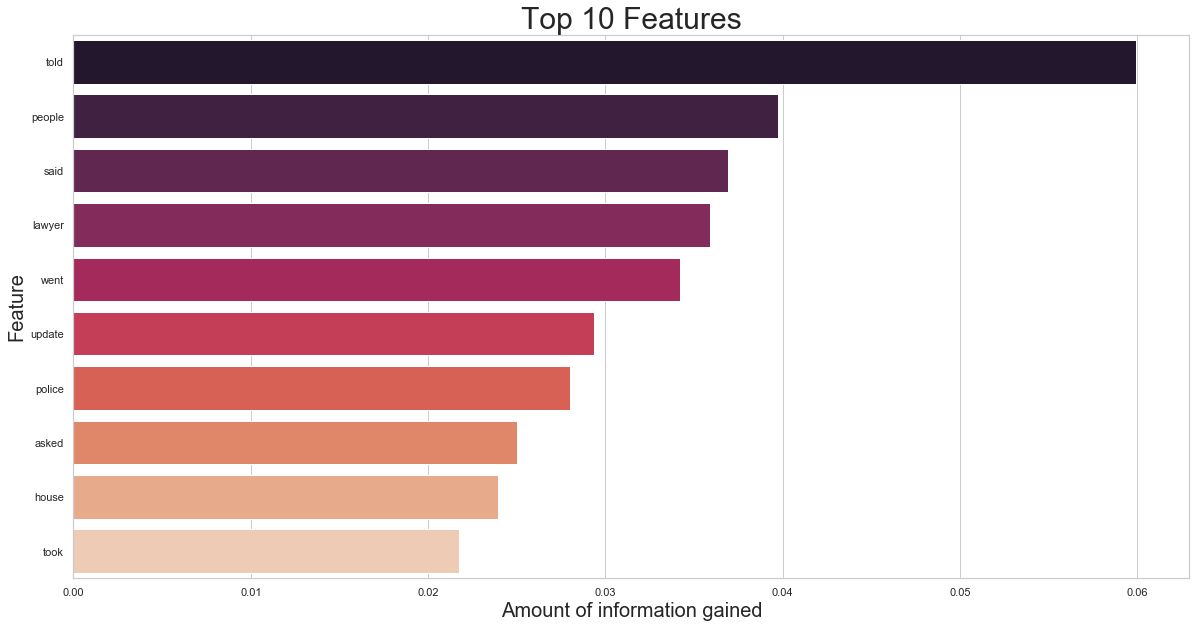

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(20,10))
sns.barplot(x=top_features["importance"], y=top_features.index,
            label="Total", palette="rocket")
plt.title('Top 10 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20)
ax.set_ylabel("Sequential");

# Finalize the plot
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.tight_layout(h_pad=2)

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

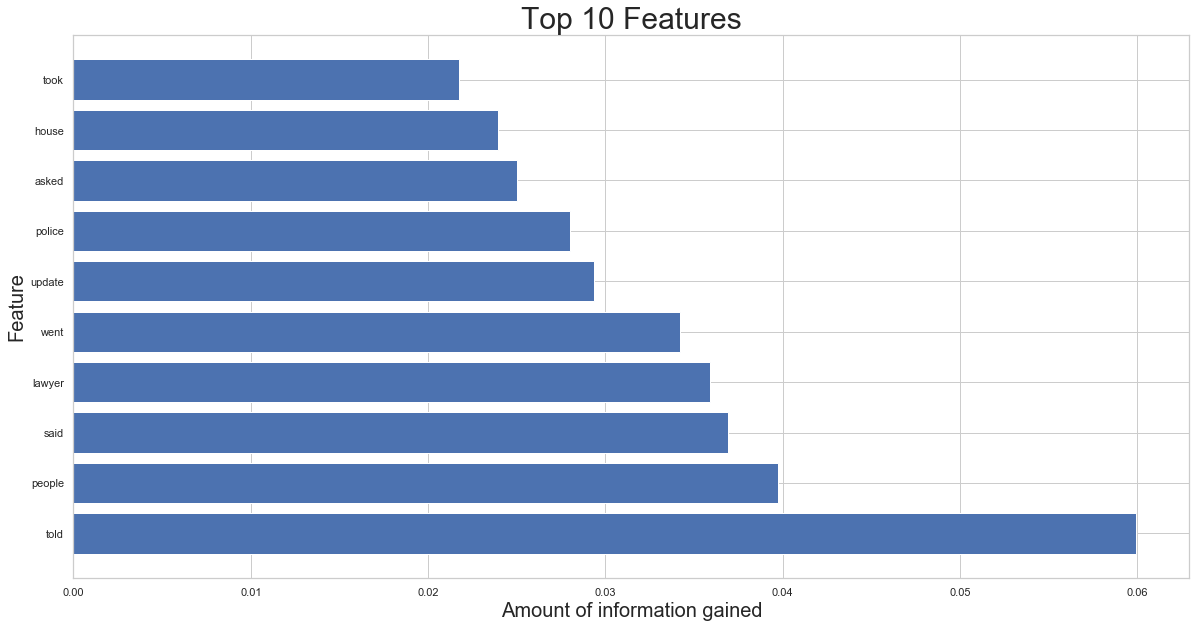

In [46]:
plt.figure(figsize=(20,10))
temp = feat_importance.sort_values('importance', ascending=False).head(10)
plt.barh(temp.index, temp['importance'])
plt.title('Top 10 Features', fontsize=30)
plt.xlabel('Amount of information gained', fontsize=20)
plt.ylabel('Feature', fontsize=20);
plt.figure

In [47]:
gs.cv_results_

{'mean_fit_time': array([0.27561369, 1.21570058, 2.3505384 , 0.22831674, 1.1301065 ,
        2.22838187, 0.21634517, 1.08190889, 2.179984  , 0.21926899,
        1.08209562, 2.15215931, 0.21511879, 1.04704051, 2.09583845,
        0.21009207, 1.02016525, 2.07266808, 0.20032077, 1.04133043,
        2.01381397, 0.19998507, 1.07761164, 2.30195808, 0.19452085,
        0.95553141, 2.14287944]),
 'std_fit_time': array([0.02401922, 0.06536765, 0.05925059, 0.00474279, 0.02497109,
        0.05095379, 0.00795136, 0.02891458, 0.04037102, 0.00415349,
        0.0374777 , 0.06274958, 0.0083663 , 0.03152155, 0.05635433,
        0.00705742, 0.03780571, 0.04186582, 0.00383335, 0.0386451 ,
        0.04899507, 0.00670547, 0.08501602, 0.18307777, 0.00378882,
        0.03329536, 0.11641541]),
 'mean_score_time': array([0.01442313, 0.06007586, 0.11456027, 0.01224403, 0.05548072,
        0.10932717, 0.01366301, 0.05374537, 0.1093318 , 0.01219521,
        0.05785646, 0.12299061, 0.01215048, 0.05451727, 0.119385

Text(0, 0.5, 'Mean Accuracy')

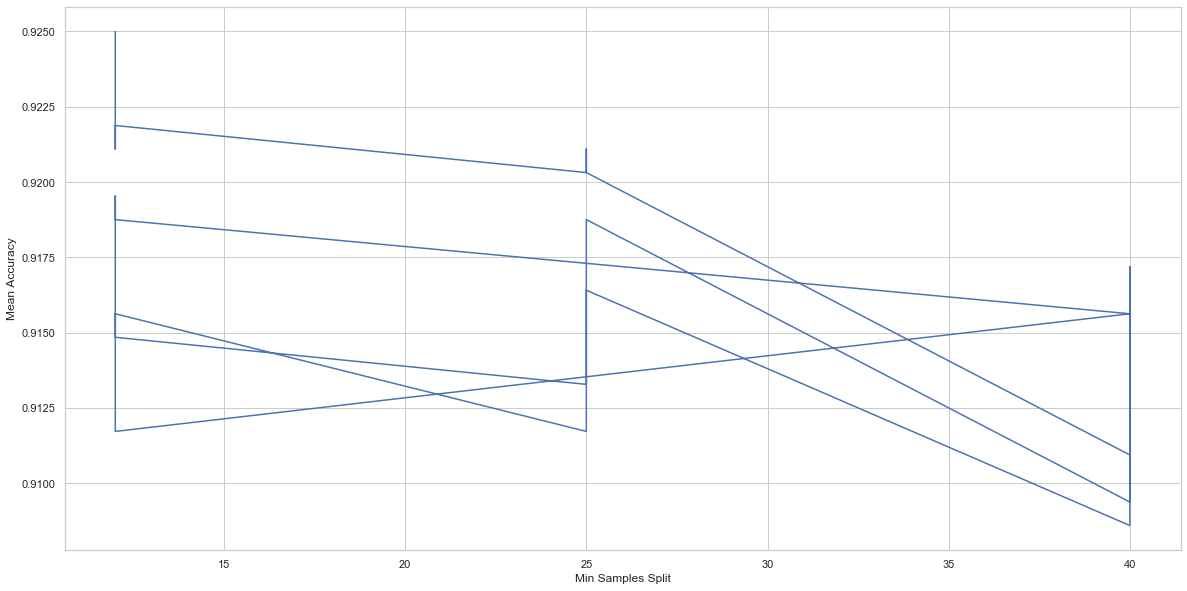

In [48]:
plt.figure(figsize=(20,10))
plt.plot([param['min_samples_split'] for param in gs.cv_results_['params']],
         gs.cv_results_['mean_test_score'])
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Accuracy')